In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm

# Dataset Exploration

In [3]:
train = pd.read_csv('../input/multi-label-image-classification-dataset/multilabel_modified/multilabel_classification(7).csv')
print(train.shape)
train.head()

(7943, 2)


,Image_Name,"Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium)"
0,image1.jpg,bus
1,image2.jpg,sitar
2,image3.jpg,flutes
3,image4.jpg,bus
4,image5.jpg,bus


In [4]:
train.columns

Index(['Image_Name', ' Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium)'], dtype='object')

In [5]:
train.rename(columns = {' Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium)':'labels'}, inplace = True)

In [6]:
train.columns

Index(['Image_Name', 'labels'], dtype='object')

In [7]:
train

,Image_Name,labels
0,image1.jpg,bus
1,image2.jpg,sitar
2,image3.jpg,flutes
3,image4.jpg,bus
4,image5.jpg,bus
...,...,...
7938,image7839.jpg,ektara flutes tabla harmonium
7939,image7840.jpg,ektara flutes tabla harmonium
7940,image7841.jpg,ektara flutes tabla harmonium
7941,image7842.jpg,ektara flutes tabla harmonium


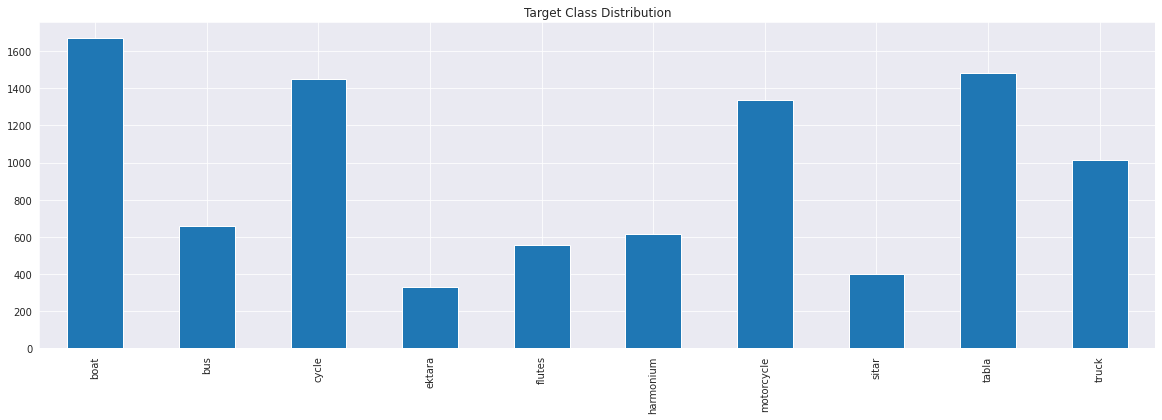

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer().fit(train.labels.apply(lambda x: x.split()))
labels = pd.DataFrame(mlb.transform(train.labels.apply(lambda x: x.split())), columns=mlb.classes_)

fig, ax = plt.subplots(figsize=(20, 6))
labels.sum().plot.bar(title='Target Class Distribution');

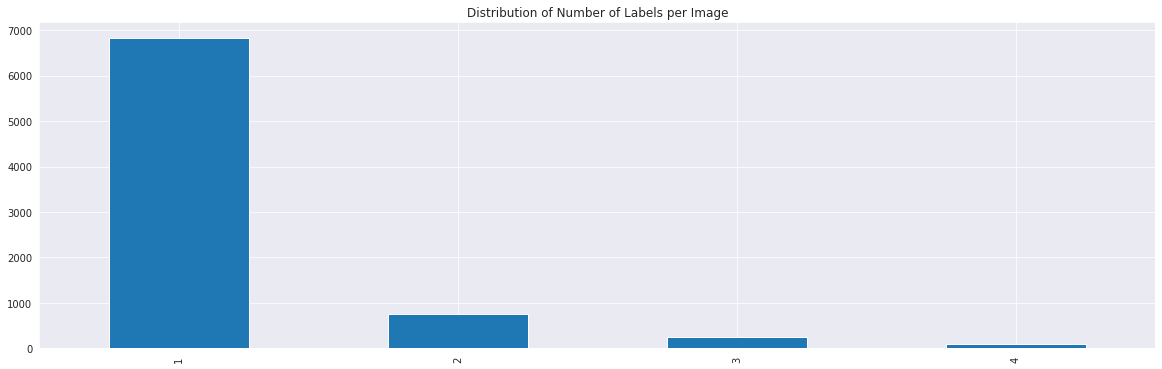

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))
labels.sum(axis=1).value_counts().plot.bar(title='Distribution of Number of Labels per Image');

IndexError: index 3 is out of bounds for axis 0 with size 3

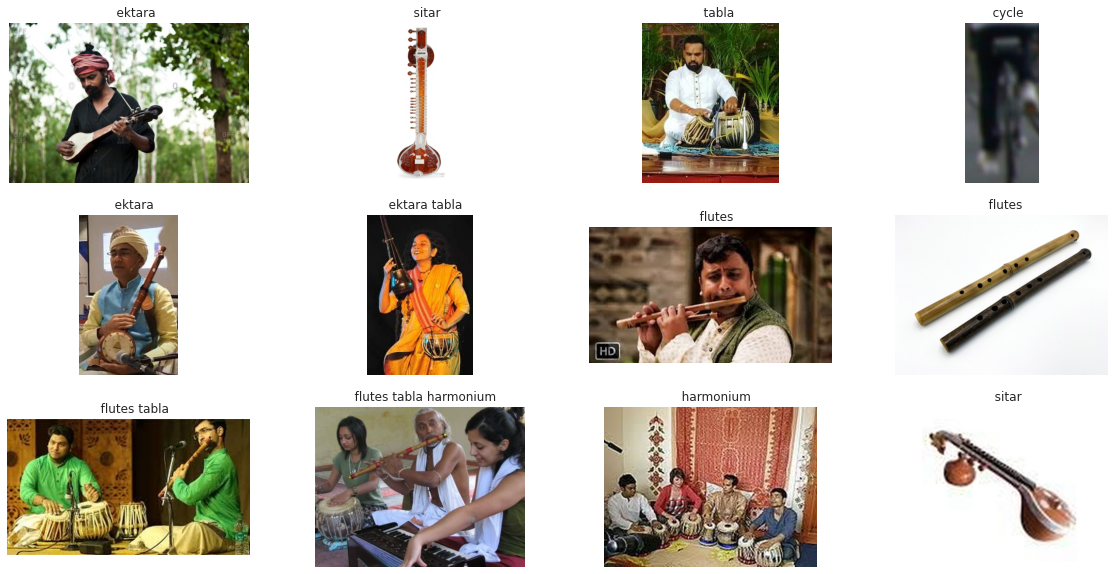

In [10]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
for i, img in enumerate(train.groupby('labels').first().reset_index().values):
    ax[i//4][i%4].imshow(plt.imread(f"../input/multi-label-image-classification-dataset/multilabel_modified/images/{img[1]}"))
    ax[i//4][i%4].set_title(img[0])
    ax[i//4][i%4].axis('off')
fig.suptitle('Image Samples', fontsize=18); 

# Preprocessing and Augmentation

In [11]:
labels = pd.concat([train['Image_Name'], labels], axis=1) #.drop('healthy', axis=1)
labels.head()

,Image_Name,boat,bus,cycle,ektara,flutes,harmonium,motorcycle,sitar,tabla,truck
0,image1.jpg,0,1,0,0,0,0,0,0,0,0
1,image2.jpg,0,0,0,0,0,0,0,1,0,0
2,image3.jpg,0,0,0,0,1,0,0,0,0,0
3,image4.jpg,0,1,0,0,0,0,0,0,0,0
4,image5.jpg,0,1,0,0,0,0,0,0,0,0


In [12]:
batch_size=128
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory='../input/multi-label-image-classification-dataset/multilabel_modified/images',
    x_col='Image_Name',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=batch_size,
    subset='training'
)

valid_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory='../input/multi-label-image-classification-dataset/multilabel_modified/images',
    x_col='Image_Name',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=batch_size,
    subset='validation'
)

Found 7149 validated image filenames.
Found 794 validated image filenames.


# Modelling

9420800/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________


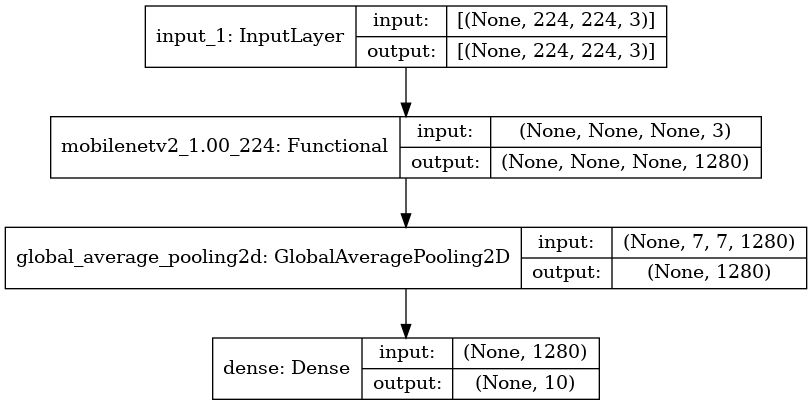

In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.MobileNetV2(include_top=False)(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)
#model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
type(train_generator)
type(valid_generator)

keras.preprocessing.image.DataFrameIterator

In [15]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[rlp, es])

Epoch 1/5
56/56 [==============================] - 103s 2s/step - loss: 0.0634 - accuracy: 0.8431 - val_loss: 0.5779 - val_accuracy: 0.6537
Epoch 2/5
56/56 [==============================] - 65s 1s/step - loss: 0.0182 - accuracy: 0.8798 - val_loss: 0.7007 - val_accuracy: 0.7065

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 3/5
56/56 [==============================] - 65s 1s/step - loss: 0.0108 - accuracy: 0.9029 - val_loss: 0.5857 - val_accuracy: 0.7557

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-07.
Epoch 4/5
56/56 [==============================] - 65s 1s/step - loss: 0.0099 - accuracy: 0.9046 - val_loss: 0.4786 - val_accuracy: 0.7909
Epoch 5/5
56/56 [==============================] - 65s 1s/step - loss: 0.0097 - accuracy: 0.9071 - val_loss: 0.3888 - val_accuracy: 0.8149


<AxesSubplot:title={'center':'Model Loss Curve'}>

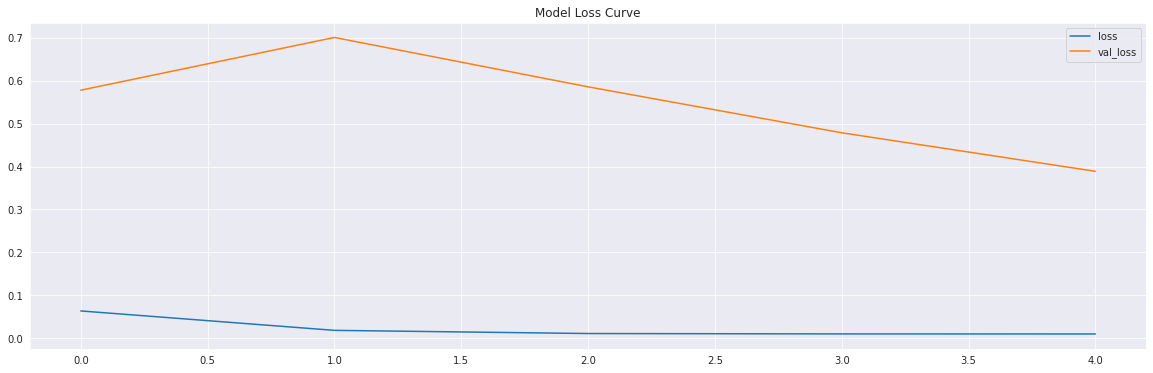

In [16]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax, title='Model Loss Curve')

<AxesSubplot:title={'center':'Model Accuracy Curve'}>

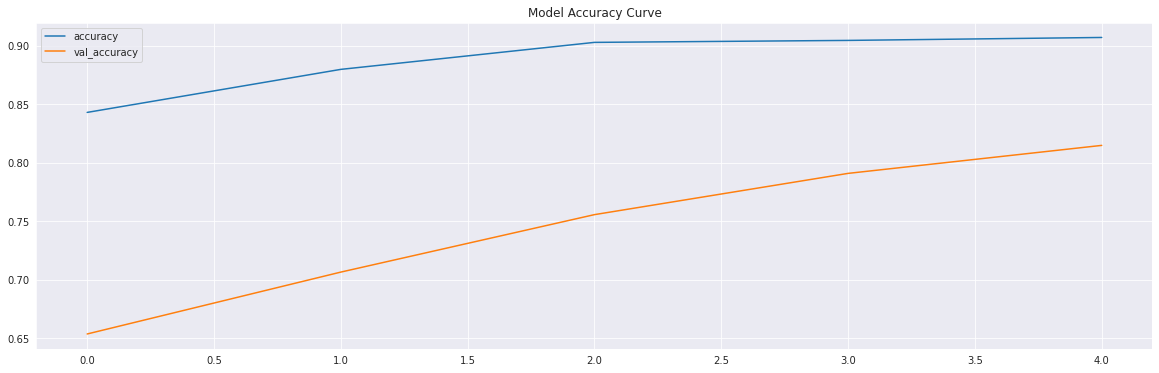

In [17]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax=ax, title='Model Accuracy Curve')

In [18]:
l=pd.DataFrame(history.history)[["loss"]].min()
v_l=pd.DataFrame(history.history)[["val_loss"]].min()
a=pd.DataFrame(history.history)[["accuracy"]].max()
v_a=pd.DataFrame(history.history)[["val_accuracy"]].max()
print(l,v_l,a,v_a)

loss    0.009719
dtype: float64 val_loss    0.388825
dtype: float64 accuracy    0.90712
dtype: float64 val_accuracy    0.814861
dtype: float64


In [19]:
#saving the model
model.save('mobilenetv2_real2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Image: /kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image1010.jpg
Top 1: ektara (Probability: 1.00)
Top 2: truck (Probability: 0.00)
Top 3: flutes (Probability: 0.00)
Top 4: bus (Probability: 0.00)
Top 5: tabla (Probability: 0.00)


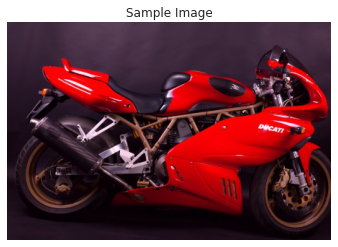

Image: /kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image2002.jpg
Top 1: cycle (Probability: 1.00)
Top 2: flutes (Probability: 0.00)
Top 3: truck (Probability: 0.00)
Top 4: bus (Probability: 0.00)
Top 5: ektara (Probability: 0.00)


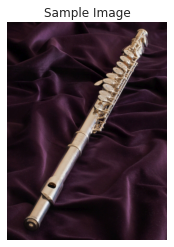

Image: /kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image3003.jpg
Top 1: boat (Probability: 0.80)
Top 2: bus (Probability: 0.18)
Top 3: truck (Probability: 0.02)
Top 4: flutes (Probability: 0.00)
Top 5: cycle (Probability: 0.00)


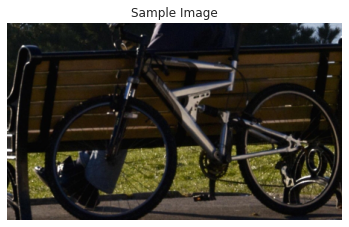

Image: /kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image4024.jpg
Top 1: motorcycle (Probability: 0.67)
Top 2: cycle (Probability: 0.22)
Top 3: flutes (Probability: 0.09)
Top 4: bus (Probability: 0.01)
Top 5: truck (Probability: 0.01)


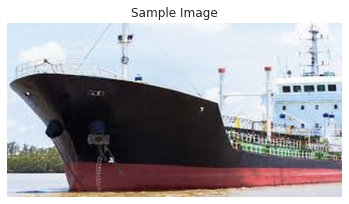

In [26]:
from tensorflow.keras.preprocessing import image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Rescale the image
    return img

# List of sample image paths
sample_image_paths = [
    '/kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image1010.jpg',
    '/kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image2002.jpg',
    '/kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image3003.jpg',
    '/kaggle/input/multi-label-image-classification-dataset/multilabel_modified/images/image4024.jpg',
]

# Make predictions on the sample images
for image_path in sample_image_paths:
    img = preprocess_image(image_path)
    predictions = model.predict(img)

    class_labels = ["motorcycle", "truck", "boat", "bus", "cycle", "sitar", "ektara", "flutes", "tabla", "harmonium"]
    top_classes = np.argsort(predictions[0])[::-1][:5]  # Get the top 5 classes with the highest probabilities

    print("Image:", image_path)
    for i, class_index in enumerate(top_classes):
        class_label = class_labels[class_index]
        probability = predictions[0][class_index]
        print(f"Top {i + 1}: {class_label} (Probability: {probability:.2f})")

    # Display the sample image
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.title("Sample Image")
    plt.axis('off')
    plt.show()